# VAA

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 7.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [74]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [75]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [76]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [77]:
start = "2003"
end = "2022-10-31"

In [78]:
#공격형 자산
SPY = getCloseDataPandas("SPY",start, end) #1
EFA = getCloseDataPandas("EFA",start, end) #2
EEM = getCloseDataPandas("EEM",start, end) #3
AGG = getCloseDataPandas("AGG",start, end) #4

#안전자산
LQD = getCloseDataPandas("LQD",start, end) #5
IEF = getCloseDataPandas("IEF",start, end)  # 6
SHY = getCloseDataPandas("SHY",start, end) #7


closeDataSet = pd.concat([SPY,EFA, EEM,AGG, LQD, IEF,SHY], axis=1)
closeDataSet.columns = ["SPY","EFA", "EEM","AGG", "LQD", "IEF",'SHY']
closeDataSet.dropna(inplace=True)
closeDataSet

,SPY,EFA,EEM,AGG,LQD,IEF,SHY
Date,,,,,,,
2003-09-29,100.930000,39.500000,15.151111,102.169998,111.550003,85.760002,82.559998
2003-09-30,99.949997,39.000000,15.103333,102.699997,112.290001,86.589996,82.730003
2003-10-01,102.080002,40.279999,15.500000,102.650002,111.879997,86.239998,82.650002
2003-10-02,102.449997,40.216667,15.722222,102.489998,111.449997,85.930000,82.650002
2003-10-03,103.389999,40.803333,15.877778,101.750000,109.900002,84.739998,82.440002
...,...,...,...,...,...,...,...
2022-10-25,384.920013,59.279999,34.209999,94.559998,100.760002,94.180000,81.000000
2022-10-26,382.019989,59.840000,34.770000,94.980003,101.220001,94.660004,81.070000
2022-10-27,379.980011,59.279999,34.500000,95.459999,101.690002,95.330002,81.239998


In [79]:
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [80]:
name_list = ["SPY","EFA", "EEM","AGG", "LQD", "IEF",'SHY']

weight = priceOnRebalDate.copy()
final_weight = pd.DataFrame( index = priceOnRebalDate.index, columns=priceOnRebalDate.columns)

for i in name_list:
  weight['mthavg_'+i] = ( 12 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(1)) -1)) +( 4 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(3)) -1))+( 2 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(6)) -1))+( 1 * ((priceOnRebalDate[i]/priceOnRebalDate[i].shift(12)) -1))
  
#n개월 수익률 (현재가/n개월 전가격)-1

In [81]:
weight['ff'] = np.where(( (weight['mthavg_SPY']<=0) | (weight['mthavg_EFA'] <=0) |(weight['mthavg_EEM'] <=0) | (weight['mthavg_AGG'] <=0)), 2,1)

In [82]:
for i in range(12, len(weight)):    
  if weight['ff'][i] ==1:
    weight_name = weight.iloc[i,7:11].idxmax().replace('mthavg_','')
    final_weight[weight_name][i] =1
  else:
    weight_name = weight.iloc[i,11:14].idxmax().replace('mthavg_','')
    final_weight[weight_name][i] =1
final_weight = final_weight.fillna(0)

In [83]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,weightDf=final_weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 69.640213620931
cagr: 1.2491925004134836
mdd: 12.481532243941395


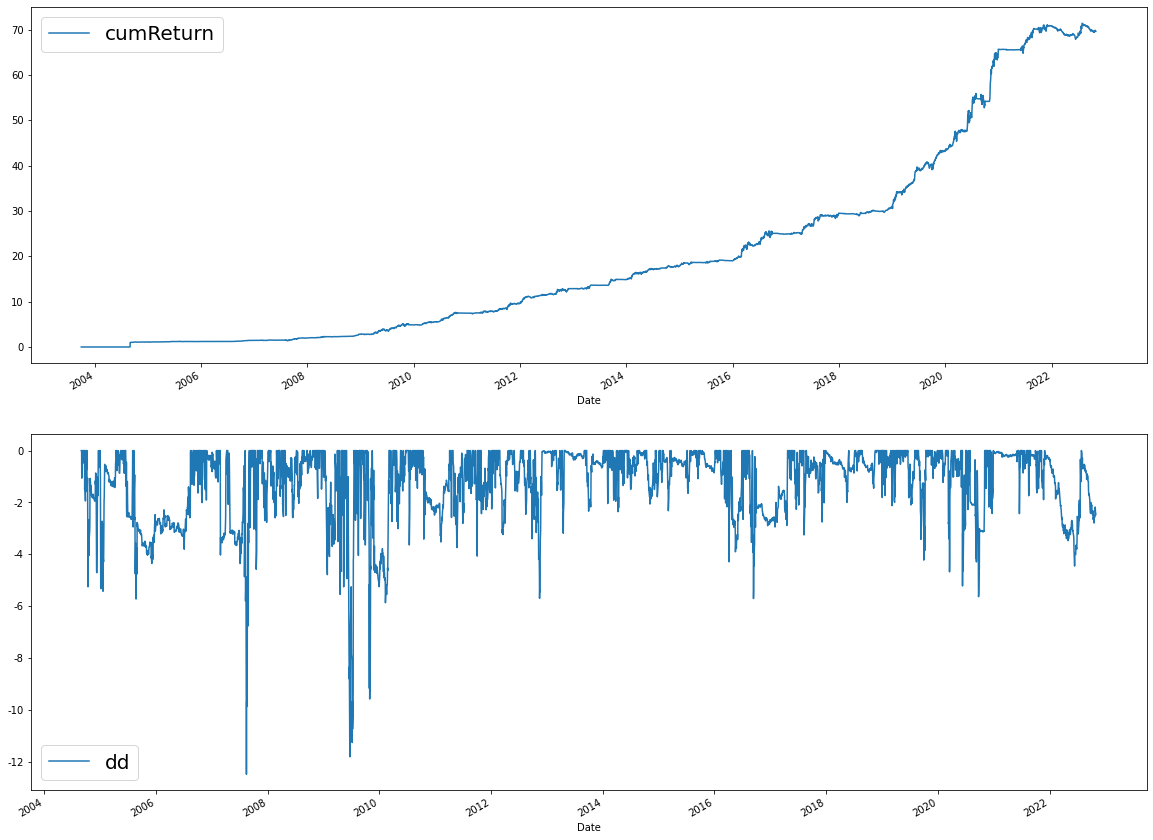

In [84]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="cumReturn")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()